In [27]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib import cm

In [28]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
ORDER = [0, 2, 3, 1]
version = 'v5_IRLS'

# Panel a

In [3]:
res_corsi = loadmat(f'../../all_corsi_log_{version}.mat')['all_corsi'][0]
_jid = res_corsi[0].flat[0]
age_corsi = _jid[3]
gender_corsi = _jid[4]
print(age_corsi.shape)

res_2back = loadmat(f'../../all_2back_log_{version}.mat')['all_2back'][0]
_jid = res_2back[0].flat[0]
age_2back = _jid[3]
gender_2back = _jid[4]
print(age_2back.shape)

res_rtime = loadmat(f'../../all_rtime_log_{version}.mat')['all_r_time']
_jid = res_rtime[0][0].flat[0]
age_sRT = _jid[3]
print(age_sRT.shape)
_jid = res_rtime[1][0].flat[0]
age_cRT = _jid[3]
gender_cRT = _jid[4]
print(age_cRT.shape)

res_switch = loadmat(f'../../all_switch_log_{version}.mat')['all_switch']
_jid = res_switch[0][0].flat[0]
age_global = _jid[3]
gender_global = _jid[4]
print(age_global.shape)
_jid = res_switch[1][0].flat[0]
age_local = _jid[3]
print(age_local.shape)

(157, 1)
(112, 1)
(164, 1)
(165, 1)
(108, 1)
(108, 1)


,75th,25th,min,N,type,females,max,50th
0,67.0,45.00,20,165,Reaction time,107,85,60.0
1,67.0,40.25,20,112,2-back,73,85,59.0
2,67.0,46.00,20,157,Corsi,102,85,60.0
3,67.0,44.50,20,108,Task switch,76,85,58.5


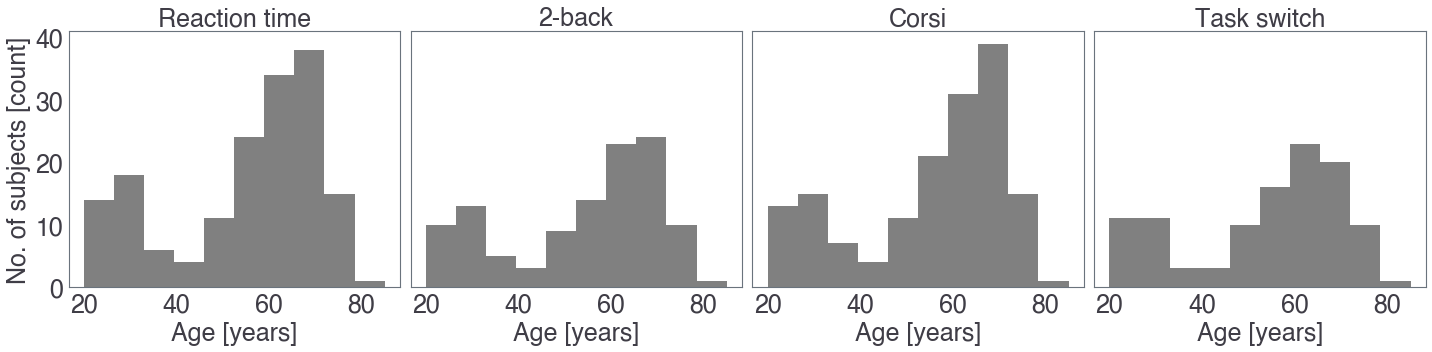

In [30]:
df_fig3pana = pd.DataFrame(columns={'type', 'N', 'females', 'min', 'max', '25th', '50th', '75th'})
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
for i, (_title, values, genders) in enumerate(zip(['Reaction time', '2-back', 'Corsi', 'Task switch'], 
                                         [age_cRT, age_2back, age_corsi, age_global], 
                                         [gender_cRT, gender_2back, gender_corsi, gender_global])):  
    
    ax[i].hist(values, color='grey')
    ax[i].set_title(_title)
    ax[i].set_xlabel('Age [years]')
    ax[i].grid(False)
#     ax[i].text(20, 36, f"N = {len(values)}", fontsize=25)
    df_fig3pana = df_fig3pana.append({'type': _title, 'N': len(values), 'females': np.sum(genders == 2),
                                      'min': np.min(values), 'max': np.max(values), 
                                      '25th': np.percentile(values, 25), 
                                      '50th': np.percentile(values, 50),
                                      '75th': np.percentile(values, 75)}, ignore_index=True)
ax[0].set_ylabel("No. of subjects [count]");
plt.tight_layout()
plt.savefig('figure_3_panel_a.pdf')
df_fig3pana.to_csv('figure_3_panel_a.csv', index=False)
df_fig3pana

# Panel b

In [4]:
res_sRT = res_rtime[0]
res_cRT = res_rtime[1]
res_global = res_switch[0]
res_local = res_switch[1]

In [ ]:
TITLES = ['sRT', 'cRT' , 'switchGlobal', 'switchLocal', 'corsi', '2back'] 
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]
              
    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))
    
tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none')
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-15, 51, 't-value', size=22)    
ax[1][0].text(-10, 51, r'$R^2$', size=22)    

plt.savefig(f'figure_3_panel_b_{TITLES[IDX]}.pdf', transparent=True)

# Panel c

<ipython-input-33-24f49250011a>:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,f-value,JID,p-value,R2,N,beta
0,46.390084,Full,1.110223e-16,0.402382,165,-0.006426
1,22.515372,Social,2.421472e-09,0.310261,163,-0.003826
2,39.651443,Transition,1.032507e-14,0.376206,163,-0.003722
3,8.043252,Launcher,4.714835e-04,0.159177,161,-0.002669


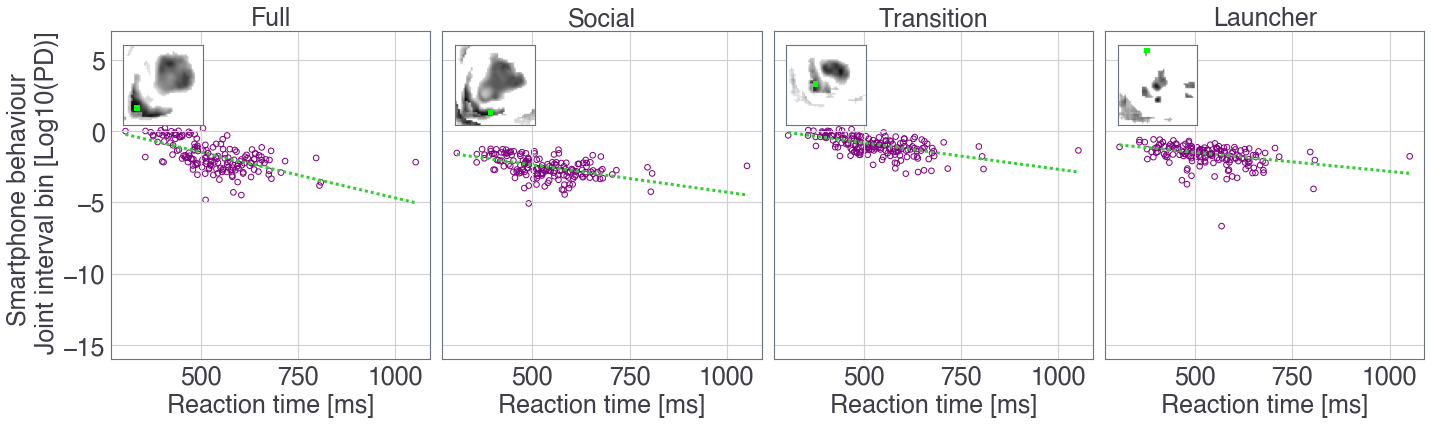

In [33]:
df_fig3panc = pd.DataFrame(columns={'JID', 'N', 'R2', 'p-value', 'f-value', 'beta'})

TITLES = ['sRT', 'cRT', 'switchGlobal', 'switchLocal', 'corsi', '2back'] 
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]
XLABELS = ['Reaction time [ms]', 'Reaction time [ms]', 'Global cost [a.u.]', 'Local cost [a.u.]', 'Span [count]', "Sensitivity [D']"]

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 1

fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):
    
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    A = data_it[3].squeeze()
    B = data_it[4].squeeze()
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]
    
    r2_full[r2_full > 1] = 0
    
    idx = np.argmax(r2_full)
    _y = A[:, idx]
    _x = B[:, 0]
    _min = np.argmin(_x)
    _max = np.argmax(_x)
    MM = B @ betas.T
    mm = MM[:, idx]
    
    ax[i].scatter(_x, _y, facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[i].plot([_x[_min], _x[_max]], [mm[_min], mm[_max]], 'limegreen', dashes=[1, 1], linewidth=3, label="Linear Fit")
    
#     _ylim = list(ax[i].get_ylim())
#     _ylim[1] += 3
    ax[i].set_ylim([-16, 7])
    ax[i].set_title(_title)
    ax[i].set_xlabel(XLABELS[IDX])

#     ax[i].text(0.1, 2.3, f"R2 = {r2_full[idx]:.2f}", fontsize=20)
    df_fig3panc = df_fig3panc.append({'JID': _title, 'N': len(_x), 
                                      'R2': r2_full[idx], 'p-value': p_full[idx], 
                                      'f-value': f_full[idx], 'beta':betas[idx, 0]}, ignore_index=True)
    
    inset_ax = inset_axes(ax[i],
                          height="25%", # set height
                          width="25%", # and width
                          loc='upper left') # center, you can check the different codes in plt.legend?
    
    square_r2_full = r2_full.reshape(50, 50).T
    
    inset_ax.imshow(np.sign(mask_full) * square_r2_full, cmap='binary')
    inset_ax.xaxis.set_visible(False)
    inset_ax.yaxis.set_visible(False)
    inset_ax.grid(False)
    inset_ax.invert_yaxis()
    x1 = idx % 50
    y1 = idx // 50;
    rect1 = matplotlib.patches.Rectangle((y1, x1), 2, 2, linewidth=2, edgecolor='lime', facecolor='lime')
    inset_ax.add_patch(rect1)
    
ax[0].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]");
plt.tight_layout()
plt.savefig(f"figure_3_panel_c_{TITLES[IDX]}.pdf", transparent=True)
df_fig3panc.to_csv(f'figure_3_panel_c_{TITLES[IDX]}.csv', index=False)
df_fig3panc

# Panel d

<ipython-input-46-d1b5034b8744>:38: UserWarning: No contour levels were found within the data range.
  im = ax[i].contour(Z * np.sign(mask_full) * np.sign(masks_uni[0]), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)
<ipython-input-46-d1b5034b8744>:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


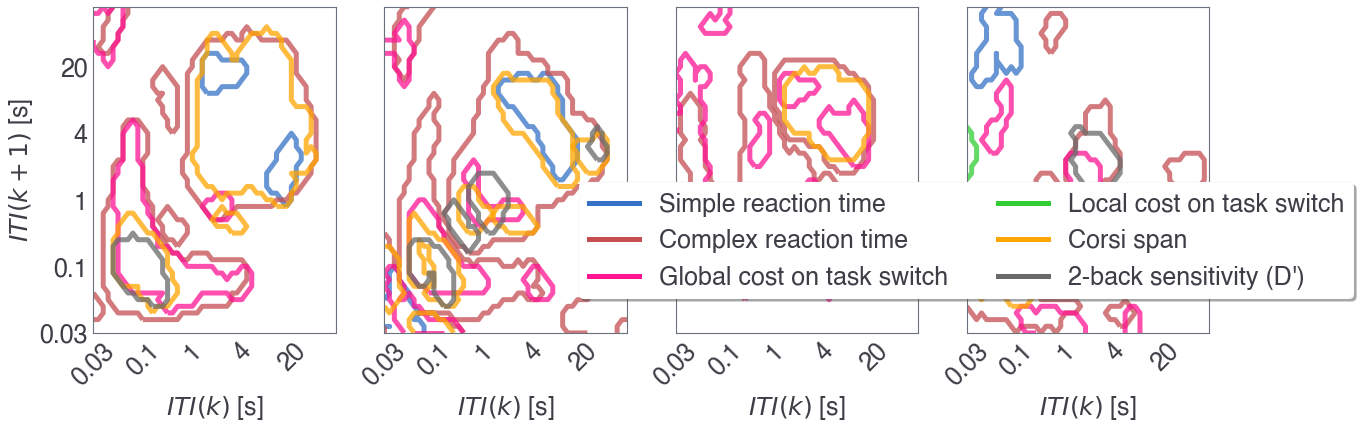

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]
# VALUES = [res_cRT, res_sRT]
# CMAPS = ['Reds', 'Blues', 'Purples', 'Greens', 'Oranges','Greys']
CMAPS = ['b', 'r', 'deeppink', 'limegreen', 'orange', 'dimgrey']
TITLES = ['Simple reaction time', 'Complex reaction time', 'Global cost on task switch', 'Local cost on task switch', 'Corsi span', "2-back sensitivity (D')"] 
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

x = np.arange(1.5, 5, (5 - 1.5) / 50)
X, Y = np.meshgrid(x, x)
Bs = []
for i, _title in enumerate(['Full',  'Social', 'Transition', 'Launcher']):
    for IDX, V in enumerate(VALUES):
        data_it = V[ORDER[i]].flat[0][1].flat[0]
        masks = [m[0].reshape(50, 50).T for m in data_it[0]]
        masks_uni = masks[:-1]
        mask_full = masks[-1]
        mdl = data_it[2]
        Bs.append(data_it[4])
        f_full = np.zeros(2500)
        f_uni = np.zeros((2500, 2))

        # mdl is 2500 long
        for j, obj in enumerate(mdl):
            pixel = obj.flat[0][0][0]
            f_uni[j] = continuous[0]
            if "OLS" in version:
                f_full[j] = pixel[4][0][0]
            else:
                f_full[j] = pixel[1][0][0]

        square_f = f_uni[:, 0].reshape(50, 50).T
        Z = square_f
        norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
        
#         im = ax[i].contour(Z * np.sign(mask_full), [2, 8, 16], colors=CMAPS[IDX], alpha=1, norm=norm, linestyles=['dotted', '--', '-'])
        im = ax[i].contour(Z * np.sign(mask_full) * np.sign(masks_uni[0]), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)
        ax[i].plot([0], [0], color=CMAPS[IDX], label=TITLES[IDX], linewidth=5)
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(labels)
        ax[i].xaxis.set_tick_params(rotation=45)
        ax[i].set_yticks(ticks)
        ax[i].set_yticklabels(labels)
        ax[i].set_xlabel(r'$ITI(k)$ [s]')
        ax[i].grid(False)
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[3].legend(loc='upper center', shadow=True, fancybox=True, ncol=2, bbox_to_anchor=[0, 0.5])
plt.tight_layout()
plt.savefig('figure_3_panel_d_legend.pdf')

# S3

In [ ]:
res_multi = loadmat(f'../../all_multitest_log_{version}.mat')['all_multitest'][0]

In [ ]:
i = 0
data_it = res_multi[ORDER[i]].flat[0][1].flat[0]
mdl = data_it[2]
A = data_it[3]
B = data_it[4]
print(B.shape)

In [ ]:
plt.scatter(B[:, 0], B[:, 1])

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = res_multi[ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
#     f_uni = np.zeros((2500, 2))
#     p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 8))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[3][0][0]
        f_full[j] = pixel[4][0][0]
        p_full[j] = pixel[6][0][0]
        betas[j] = pixel[2].squeeze()
        continuous = pixel[7][0][0]
#         f_uni[j] = continuous[0]
#         p_uni[j] = continuous[2]

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_full.reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(square_f, 99))
    vmin_f = min(vmin_f, np.percentile(square_f, 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = res_multi[ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 7))
    p_uni = np.zeros((2500, 7))
    betas = np.zeros((2500, 8))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]

#     k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    for jj in range(6):
        square_f = f_uni[:, jj].reshape(50, 50).T
        square_f[square_f < 0] = 0
        Z = square_f
        norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
        im = ax[0][i].contour(Z * np.sign(masks_uni[jj]), [2], colors=CMAPS[jj], alpha=.75, norm=norm, linewidths=5)
    
#     im = ax[0][i].imshow(np.sign(mask_full) * square_f, aspect='auto', 
#                          cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmax=vmax_f))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

#     ax[0][i].invert_yaxis()
#     ax[0][i].set_xticks(ticks)
#     ax[0][i].set_xticklabels(labels)
#     ax[0][i].xaxis.set_tick_params(rotation=45)
#     ax[0][i].set_yticks(ticks)
#     ax[0][i].set_yticklabels(labels)
# #     ax[0][i].set_xlabel('ITI(k) [s]')
#     ax[0][i].grid(False)
#     divider = make_axes_locatable(ax[0][i])
#     cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
#     fig.add_axes(cax)
#     cb = fig.colorbar(im, cax=cax, orientation="horizontal")
#     cb.ax.xaxis.set_ticks_position('top')
#     _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
    square_r2_full = r2_full.reshape(50, 50).T
    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='GnBu', 
#                          interpolation='none', norm=Normalize(0, vmax_r))
                        interpolation='none')
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel('ITI(k) [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel('ITI(k + 1) [s]');
ax[1][0].set_ylabel('ITI(k + 1) [s]');
# plt.tight_layout()
# if IDX == 0:
# plt.savefig(f'figure_2_panel_b_{TITLES[IDX]}.pdf', transparent=True)
# else:
#     plt.savefig('figure_1_supplementary_ii.pdf', transparent=True)